In [1]:
import svhn
from mrcnn import visualize
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib

import numpy as np

/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gmelissari/mi

### dataset location info

In [2]:
info = {'train': {'label_file_path':"../../dataset/SVHN/train/annots/labels.txt",
                   'annotation_dir': "../../dataset/SVHN/train/annots/",
                   'images_dir': "../../dataset/SVHN/train/images/"},
         'test':{'label_file_path':"../../dataset/SVHN/test/annots/labels.txt",
                   'annotation_dir': "../../dataset/SVHN/test/annots/",
                   'images_dir': "../../dataset/SVHN/test/images/"},
         'saved_model_dir': "../../weights/SVHN/",
         'coco_weights_path': "../../weights/mask_rcnn_coco.h5"}

### create training and test set

In [3]:
# Training dataset
dataset_train = svhn.SVHNDataset()
class_info, train_image_info = dataset_train.load_svhn(info['train']['label_file_path'], 
                                                 info['train']['annotation_dir'], 
                                                 info['train']['images_dir'])
dataset_train.prepare()

# Validation dataset
dataset_val = svhn.SVHNDataset()
class_info, val_image_info = dataset_val.load_svhn(info['test']['label_file_path'], 
                                                 info['test']['annotation_dir'], 
                                                 info['test']['images_dir'])
dataset_val.prepare()

train_image_info, val_image_info, class_info

([{'id': 0,
   'source': 'svhn',
   'path': '../../dataset/SVHN/train/images/1.png',
   'width': 741,
   'height': 350,
   'polygons': [{'all_x': [280.1494077702159,
      307.37265898428353,
      322.9287722586692,
      301.81689516047845,
      315.7063047199911,
      314.039558618004,
      263.48211629880075,
      262.926548393843,
      279.0382295731864,
      296.81669924163106,
      277.92709376327105],
     'all_y': [94.8611153496636,
      77.08333333333331,
      77.63890160454643,
      258.1944359673394,
      260.4166666666667,
      271.5277777777777,
      267.6389058430989,
      256.52779473198785,
      254.86111111111106,
      105.97222646077472,
      104.30556403266057],
     'class_name': '1'},
    {'all_x': [369.31939171001864,
      339.3183009711626,
      327.095595126523,
      325.9844593166076,
      332.651358950328,
      343.7628865979382,
      357.65229615745085,
      373.76401972390835,
      389.32017538540816,
      400.43170303301827,
     

### load and display random samples

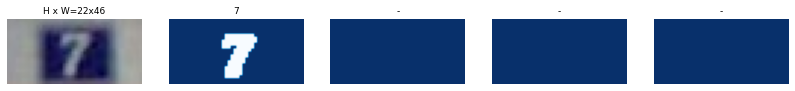

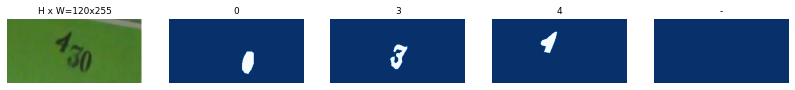

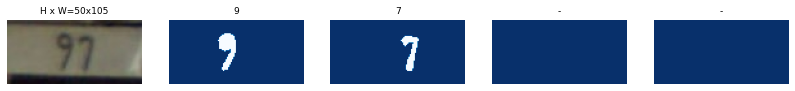

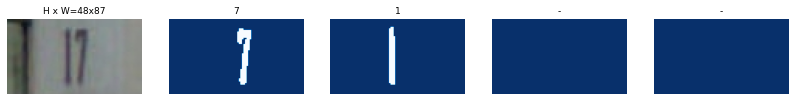

In [16]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

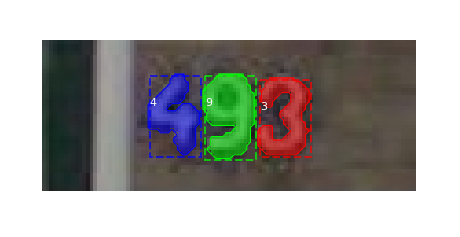

In [13]:
visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_train.class_names, figsize=(8, 8))

### Create model for training

In [4]:
# Create config class containing training properties
config = svhn.SVHNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [5]:
# Create model in training mode
model = MaskRCNN(mode="training", 
                 config = config,
                 model_dir = info['saved_model_dir'])

In [6]:
# Load MS COCO weights

# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(info['coco_weights_path'], 
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

# Load the last model you trained and continue training
#model.load_weights(model.find_last(), by_name=True)

### Training
#### Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. Simply pass layers="all to train all layers.

In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ../../weights/SVHN/svhn20200728T1511/mask_rcnn_svhn_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4        

/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  

Epoch 1/100


/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not define

  8/100 [=>............................] - ETA: 13:28 - loss: 4.6460 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 1.0556 - mrcnn_class_loss: 1.3260 - mrcnn_bbox_loss: 1.3525 - mrcnn_mask_loss: 0.8009

/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/gmelissari/miniconda3/envs/matterport/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not define

KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

### Prediction

In [4]:
inference_config = svhn.SVHNInferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [5]:
# create the model in inference mode
model = MaskRCNN(mode="inference", 
              config=inference_config,
              model_dir=info['saved_model_dir'])

In [6]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
model_path

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../../weights/SVHN/svhn20200729T1459/mask_rcnn_svhn_0100.h5
Re-starting from epoch 100


original_image           shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  128.00000  float64
gt_class_id              shape: (2,)                  min:    5.00000  max:    5.00000  int32
gt_bbox                  shape: (2, 4)                min:   38.00000  max:   92.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


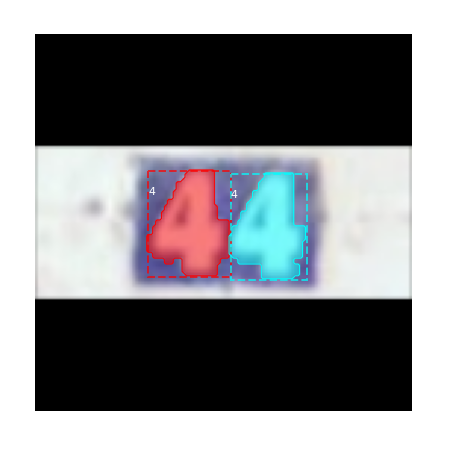

original_image           shape: (128, 128, 3)         min:    0.00000  max:  182.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  149.00000  float64
gt_class_id              shape: (2,)                  min:    2.00000  max:    7.00000  int32
gt_bbox                  shape: (2, 4)                min:   43.00000  max:   87.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


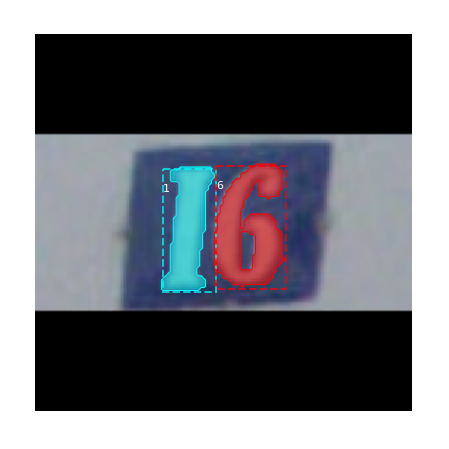

original_image           shape: (128, 128, 3)         min:    0.00000  max:  181.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  297.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    5.00000  int32
gt_bbox                  shape: (3, 4)                min:   22.00000  max:   91.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


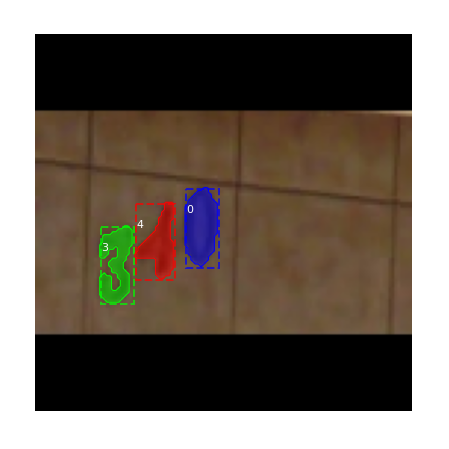

original_image           shape: (128, 128, 3)         min:    0.00000  max:  126.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  196.00000  float64
gt_class_id              shape: (2,)                  min:    2.00000  max:    7.00000  int32
gt_bbox                  shape: (2, 4)                min:   44.00000  max:   87.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


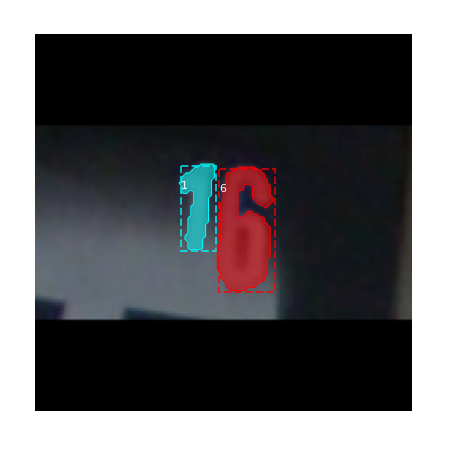

original_image           shape: (128, 128, 3)         min:    0.00000  max:  178.00000  uint8
image_meta               shape: (23,)                 min:    0.00000  max:  226.00000  float64
gt_class_id              shape: (3,)                  min:    2.00000  max:    4.00000  int32
gt_bbox                  shape: (3, 4)                min:   53.00000  max:   81.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


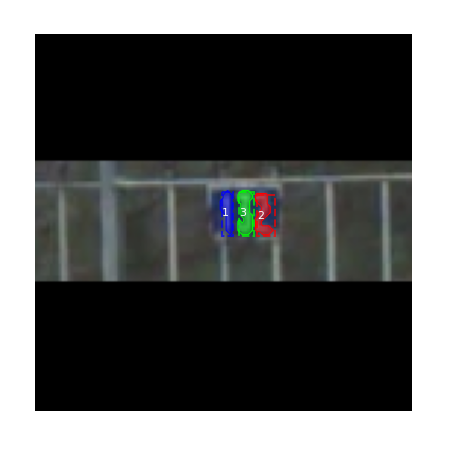

In [7]:
from mrcnn.model import log

random = True
samples = 5

if random:
    # Test on a random image
    image_ids = np.random.choice(dataset_val.image_ids, samples)
else:
    # Test on all images
    image_ids = dataset_val.image_ids

original_images = []
for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)
    
    original_images.append(original_image)
    
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  182.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   78.10000  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  181.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   57.30000

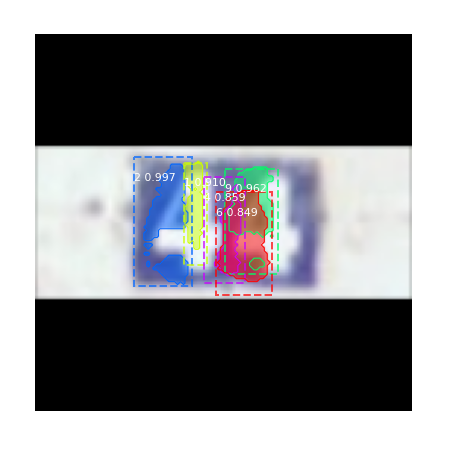

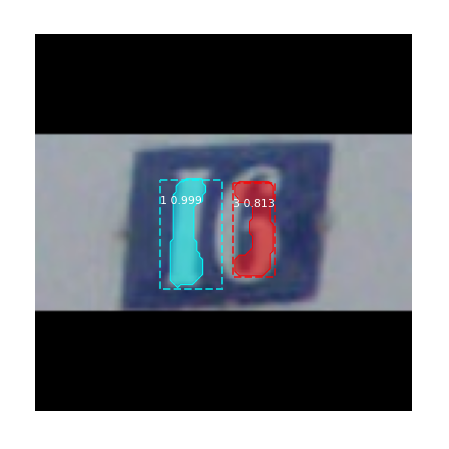

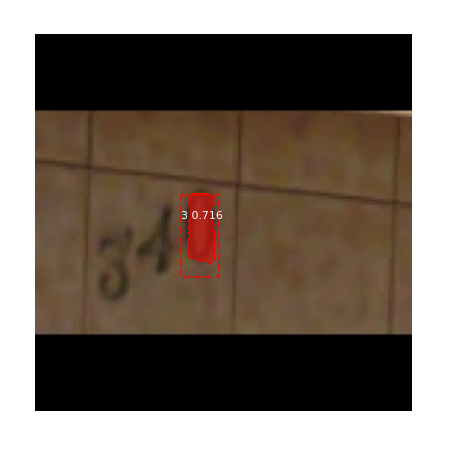

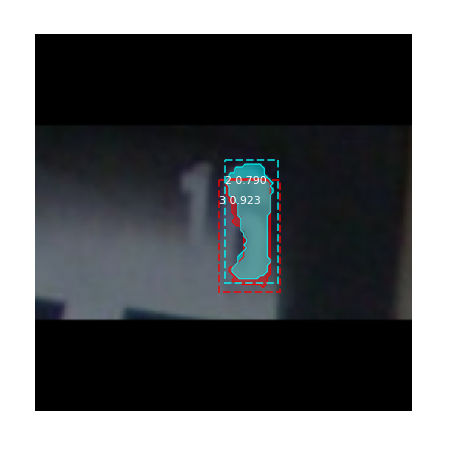

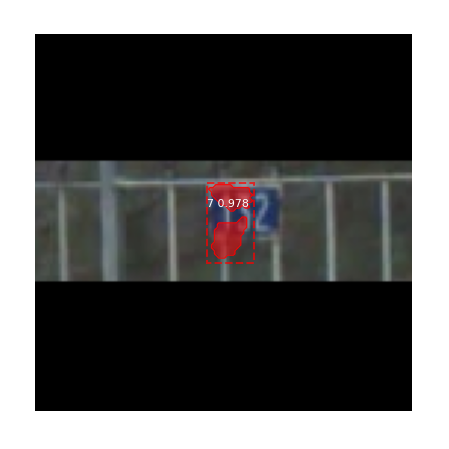

In [8]:
import matplotlib.pyplot as plt

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return fig, ax




masked_images = []
figures = []
for original_image in original_images:
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    fig, ax = get_ax()
    masked_image = visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=ax)
    masked_images.append(masked_image)
    figures.append(fig)

In [10]:
import cv2

# write the image with bounding boxes to file
prediction_dir = '/'.join(model_path.split('/')[:-1])

for figure, image_id in zip(figures, image_ids):
    image_name = dataset_val.source_image_link(image_id).split('/')[-1]
    print("saving inferred image in ", prediction_dir+'/'+image_name)
    # write the image with bounding boxes to file
    figure.savefig(prediction_dir + '/' + image_name)

saving inferred image in  ../../weights/SVHN/svhn20200729T1459/10100.png
saving inferred image in  ../../weights/SVHN/svhn20200729T1459/10016.png
saving inferred image in  ../../weights/SVHN/svhn20200729T1459/10150.png
saving inferred image in  ../../weights/SVHN/svhn20200729T1459/10007.png
saving inferred image in  ../../weights/SVHN/svhn20200729T1459/10161.png
